### Cluster NBA Players Using Kmeans

#### In NBA media coverage, sports reporters usually focus on a handful of players and paint stories of how unique these players' stats are. With our data science hats on, we can't help but feel a slight sense of skepticism to how different the players are from one another. Let's see how we can use data science to explore that thread further.

#### Let's look at the dataset of player performance from the 2013-2014 season.

#### Here are some selected columns:

- player -- name of the player
- pos -- the position of the player
- g -- number of games the player was in
- pts -- total points the player scored
- fg. -- field goal percentage
- ft. -- free throw percentage

#### Point guards play one of the most crucial roles on a team because their primary responsibility is to create scoring opportunities for the team. We are going to focus our lesson on a machine learning technique called clustering, which allows us to visualize the types of point guards as well as group similar point guards together. Using 2 features allows us to easily visualize the players and will also make it easier to grasp how clustering works. For point guards, it's widely accepted that the Assist to Turnover Ratio is a good indicator for performance in games as it quantifies the number of scoring opportunities that player created. Let's also use Points Per Game, since effective Point Guards not only set up scoring opportunities but also take a lot of the shots themselves.

#### Create a new Dataframe which contains just the point guards from the data set. Point guards are specified as PG in the pos column

In [2]:
import pandas as pd
import numpy as np

nba = pd.read_csv("nba_2013.csv")
nba.head(3)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013


In [4]:
# point guard dataframe
point_guards = nba[nba['pos'] == 'PG']
point_guards.head()

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
24,D.J. Augustin,PG,26,TOT,71,9,1939,298,718,0.415,...,115,130,313,53,3,125,147,930,2013-2014,2013
29,Leandro Barbosa,PG,31,PHO,20,0,368,56,131,0.427,...,32,37,32,7,4,19,30,150,2013-2014,2013
30,Jose Barea,PG,29,MIN,79,1,1471,254,656,0.387,...,138,154,303,26,0,125,129,660,2013-2014,2013
38,Jerryd Bayless,PG,25,TOT,72,19,1686,248,617,0.402,...,123,145,194,60,9,82,161,666,2013-2014,2013
50,Steve Blake,PG,33,TOT,55,28,1498,133,353,0.377,...,146,159,307,54,8,102,85,378,2013-2014,2013


#### While our dataset doesn't come with Points Per Game values, we can easily calculate those using each player's total points (pts) and the number of games (g) they played. Let's take advantage of pandas' ability to multiply and divide columns to create the Points Per Game ppg column by dividing the pts and g columns.

In [5]:
point_guards['ppg'] = point_guards['pts'] / point_guards['g']
# Sanity check, make sure ppg = pts/g
point_guards[['pts', 'g', 'ppg']].head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,pts,g,ppg
24,930,71,13.098592
29,150,20,7.500000
30,660,79,8.354430
38,666,72,9.250000
50,378,55,6.872727


#### Now let's create a column, atr, for the Assist Turnover Ratio, which is calculated by dividing total assists (ast) by total turnovers (tov)

In [6]:
# Drop the players who have 0 turnovers.
# Not only did these players only play a few games, 
# making it hard to understand their true abilities, but we also cannot divide by 0 when we calculate atr.
# Utilize the same division technique we used with Points Per Game 
# to create the Assist Turnover Ratio (atr) column for point_guards
point_guards = point_guards[point_guards['tov'] != 0]
point_guards['atr'] = point_guards['ast'] / point_guards['tov']

#### Use matplotlib to create a scatter plot with Points Per Game (ppg) on the X axis and Assist Turnover Ratio (atr) on the Y axis

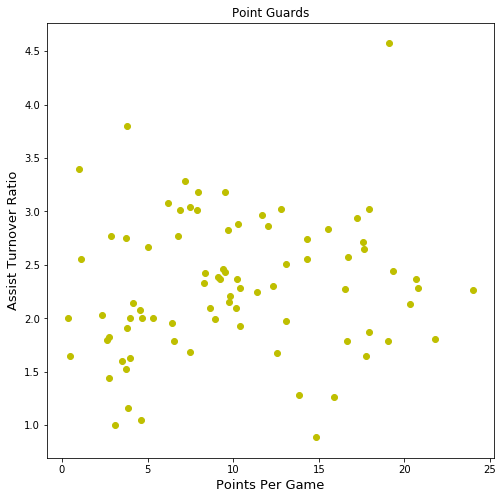

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 8))
plt.scatter(point_guards['ppg'], point_guards['atr'], c='y')
plt.title("Point Guards")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)
plt.show()

### Determine K

#### There seem to be 5 general regions, or clusters, that the point guards fall into (with a few outliers of course!). We can use a technique called clustering to segment all of the point guards into groups of alike players. While regression and other supervised machine learning techniques work well when we have a clear metric we want to optimize for and lots of pre-labelled data, we need to instead use unsupervised machine learning techniques to explore the structure within a data set that doesn't have a clear value to optimize.

#### There are multiple ways of clustering data but here we will focus on centroid based clustering for this lesson. Centroid based clustering works well when the clusters resemble circles with centers (or centroids). The centroid represent the arithmetic mean of all of the data points in that cluster.

#### K-Means Clustering is a popular centroid-based clustering algorithm that we will use. The K in K-Means refers to the number of clusters we want to segment our data into. The key part with K-Means (and most unsupervised machine learning techniques) is that we have to specify what k is. There are advantages and disadvantages to this, but one advantage is that we can pick the k that makes the most sense for our use case. We'll set k to 5 since we want K-Means to segment our data into 5 clusters.

### Kmeans algorithm

#### Setup K-Means is an iterative algorithm that switches between recalculating the centroid of each cluster and the players that belong to that cluster. To start, select 5 players at random and assign their coordinates as the initial centroids of the just created clusters.

- Step 1 (Assign Points to Clusters) For each player, calculate the Euclidean distance between that player's coordinates, or values for atr & ppg, and each of the centroids' coordinates. Assign the player to the cluster whose centroid is the closest to, or has the lowest Euclidean distance to, the player's values.

- Step 2 (Update New Centroids of the Clusters) For each cluster, compute the new centroid by calculating the arithmetic mean of all of the points (players) in that cluster. We calculate the arithmetic mean by taking the average of all of the X values (atr) and the average of all of the Y values (ppg) of the points in that cluster.

#### Iterate Repeat steps 1 & 2 until the clusters are no longer moving and have converged.

In [19]:
num_clusters = 5
# Use numpy's random function to generate a list, length: num_clusters, of indices
random_initial_points = np.random.choice(point_guards.index, size=num_clusters)
# Use the random indices to create the centroids
centroids = point_guards.loc[random_initial_points]
print(random_initial_points)
centroids

[204 374  78 293 262]


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,ast,stl,blk,tov,pf,pts,season,season_end,ppg,atr
204,George Hill,PG,27,IND,76,76,2434,272,616,0.442,...,265,75,23,92,158,781,2013-2014,2013,10.276316,2.880435
374,Rajon Rondo,PG,27,BOS,30,30,998,141,350,0.403,...,294,40,2,99,65,350,2013-2014,2013,11.666667,2.969697
78,Will Bynum,PG,31,DET,56,3,1054,184,430,0.428,...,216,39,7,103,121,485,2013-2014,2013,8.660714,2.097087
293,Ray McCallum,PG,22,SAC,45,10,897,113,300,0.377,...,120,22,9,39,69,280,2013-2014,2013,6.222222,3.076923
262,Ty Lawson,PG,26,DEN,62,61,2222,347,806,0.431,...,543,100,10,200,113,1090,2013-2014,2013,17.580645,2.715000


#### Let's plot the centroids, in addition to the point_guards, so we can see where the randomly chosen centroids started out.

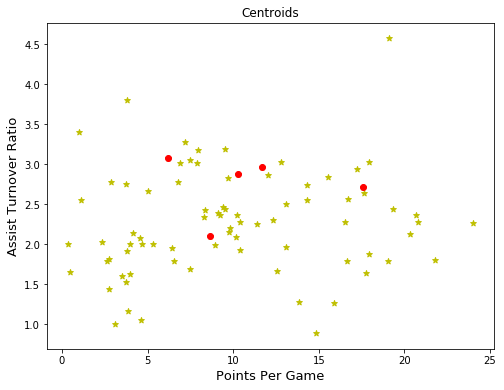

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(point_guards['ppg'], point_guards['atr'], c='y', marker='*')
plt.scatter(centroids['ppg'], centroids['atr'], c='red')
plt.title("Centroids")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)
plt.show()

#### While the centroids data frame object worked well for the initial centroids, where the centroids were just a subset of players, as we iterate the centroids' values will be coordinates that may not match another player's coordinates. Moving forward, let's use a dictionary object instead to represent the centroids.

#### We will need a unique identifier, like cluster_id, to refer to each cluster's centroid and a list representation of the centroid's coordinates (or values for ppg and atr). Let's create a dictionary then with the following mapping:

- key: cluster_id of that centroid's cluster
- value: centroid's coordinates expressed as a list ( ppg value first, atr value second )

#### To generate the cluster_ids, let's iterate through each centroid and assign an integer from 0 to k-1. For example, the first centroid will have a cluster_id of 0, while the second one will have a cluster_id of 1. We'll write a function, centroids_to_dict, that takes in the centroids data frame object, creates a cluster_id and converts the ppg and atr values for that centroid into a list of coordinates, and adds both the cluster_id and coordinates_list into the dictionary that's returned.

In [27]:
def centroids_to_dict(centroids):
    dictionary = dict()
    # iterating counter we use to generate a cluster_id
    counter = 0

    # iterate a pandas data frame row-wise using .iterrows()
    for index, row in centroids.iterrows():
        coordinates = [row['ppg'], row['atr']]
        dictionary[counter] = coordinates
        counter += 1

    return dictionary

centroids_dict = centroids_to_dict(centroids)
centroids_dict

{0: [10.276315789473685, 2.880434782608696],
 1: [11.666666666666666, 2.9696969696969697],
 2: [8.660714285714286, 2.0970873786407767],
 3: [6.222222222222222, 3.076923076923077],
 4: [17.580645161290324, 2.715]}

#### Before we can assign players to clusters, we need a way to compare the ppg and atr values of the players with each cluster's centroids. Euclidean distance is the most common technique used in data science for measuring distance between vectors and works extremely well in 2 and 3 dimensions. While in higher dimensions, Euclidean distance can be misleading, in 2 dimensions Euclidean distance is essentially the Pythagorean theorem.

In [28]:
import math

def calculate_distance(centroid, player_values):
    root_distance = 0
    
    for x in range(0, len(centroid)):
        difference = centroid[x] - player_values[x]
        squared_difference = difference**2
        root_distance += squared_difference

    euclid_distance = math.sqrt(root_distance)
    return euclid_distance

q = [5, 2]
p = [3,1]

# Sqrt(5) = ~2.24
print(calculate_distance(q, p))

2.23606797749979


#### Now we need a way to assign data points to clusters based on Euclidean distance. Instead of creating a new variable or data structure to house the clusters, let's keep things simple and just add a column to the point_guards data frame that contains the cluster_id of the cluster it belongs to.

#### Create a function that can be applied to every row in the data set.

In [30]:
# For each player, we want to calculate the distances 
# to each cluster's centroid using euclidean_distance.
# Once we know the distances, we can determine which centroid 
# is the closest (has the lowest distance) and return that centroid's cluster_id.
# point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
def assign_to_cluster(row):
    lowest_distance = -1
    closest_cluster = -1
    
    for cluster_id, centroid in centroids_dict.items():
        df_row = [row['ppg'], row['atr']]
        euclidean_distance = calculate_distance(centroid, df_row)
        
        if lowest_distance == -1:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id 
        elif euclidean_distance < lowest_distance:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id
    return closest_cluster

point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
point_guards.head()

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,stl,blk,tov,pf,pts,season,season_end,ppg,atr,cluster
24,D.J. Augustin,PG,26,TOT,71,9,1939,298,718,0.415,...,53,3,125,147,930,2013-2014,2013,13.098592,2.504000,1
29,Leandro Barbosa,PG,31,PHO,20,0,368,56,131,0.427,...,7,4,19,30,150,2013-2014,2013,7.500000,1.684211,2
30,Jose Barea,PG,29,MIN,79,1,1471,254,656,0.387,...,26,0,125,129,660,2013-2014,2013,8.354430,2.424000,2
38,Jerryd Bayless,PG,25,TOT,72,19,1686,248,617,0.402,...,60,9,82,161,666,2013-2014,2013,9.250000,2.365854,2
50,Steve Blake,PG,33,TOT,55,28,1498,133,353,0.377,...,54,8,102,85,378,2013-2014,2013,6.872727,3.009804,3


#### Let's write a function, visualize_clusters, that we can use to visualize the clusters easily.

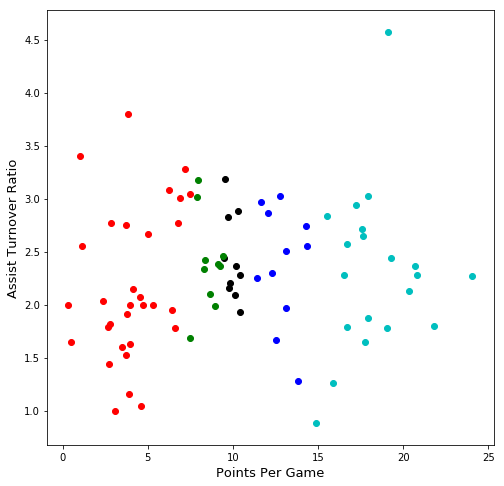

In [33]:
# Visualizing clusters
def visualize_clusters(df, num_clusters):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    plt.figure(figsize=(8, 8))
    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        plt.scatter(clustered_df['ppg'], clustered_df['atr'], c=colors[n-1])
        plt.xlabel('Points Per Game', fontsize=13)
        plt.ylabel('Assist Turnover Ratio', fontsize=13)
    plt.show()

visualize_clusters(point_guards, 5)

#### Let's code Step 2, where we recalculate the centroids for each cluster.

#### Write a function, recalculate_centroids, that:
- takes in point_guards
- uses each cluster_id(from 0 to num_clusters - 1) to pull out all of the players in each cluster
- calculates the new arithmetic mean
- and adds the cluster_id and the new arithmetic mean to new_centroids_dict, the final dictionary to be returned.

In [34]:
def recalculate_centroids(df):
    new_centroids_dict = dict()
    
    for cluster_id in range(0, num_clusters):
        values_in_cluster = df[df['cluster'] == cluster_id]
        # Calculate new centroid using mean of values in the cluster
        new_centroid = [np.average(values_in_cluster['ppg']), np.average(values_in_cluster['atr'])]
        new_centroids_dict[cluster_id] = new_centroid
    return new_centroids_dict

centroids_dict = recalculate_centroids(point_guards)
centroids_dict

{0: [9.969137877765172, 2.4363028239911153],
 1: [12.851510593612359, 2.37482190856395],
 2: [8.536382220024176, 2.3939378268892026],
 3: [4.050312593923532, 2.183616116004518],
 4: [18.36221468306436, 2.3048103622888023]}

#### Now that we recalculated the centroids, let's re-run Step 1 (assign_to_cluster) and see how the clusters shifted.

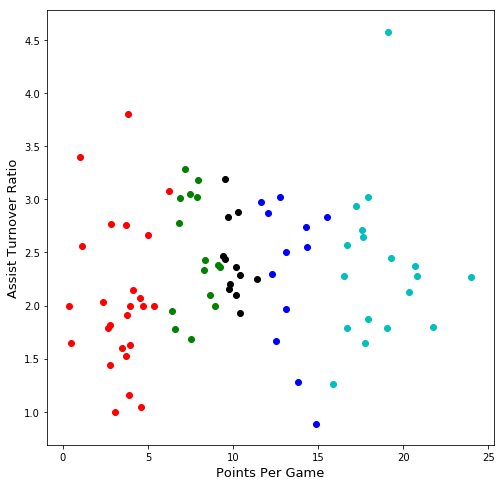

In [35]:
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)

#### Now we need to recalculate the centroids, and shift the clusters again.

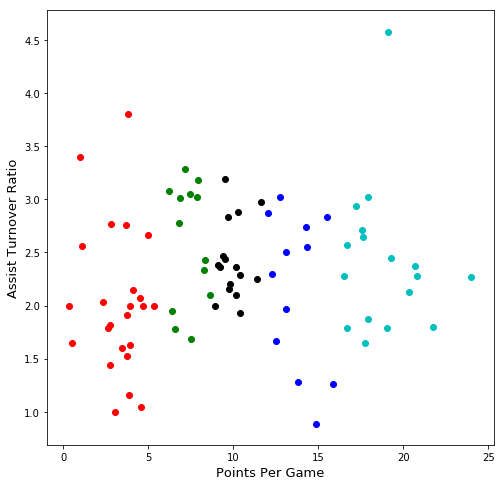

In [36]:
centroids_dict = recalculate_centroids(point_guards)
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)

#### As we repeat Steps 1 and 2 and run visualize_clusters, we notice that a few of the points are changing clusters between every iteration (especially in areas where 2 clusters almost overlap), but otherwise, the clusters visually look like they don't move a lot after every iteration. This means 2 things:

#### K-Means doesn't cause massive changes in the makeup of clusters between iterations, meaning that it will always converge and become stable

#### Because K-Means is conservative between iterations, where we pick the initial centroids and how we assign the players to clusters initially matters a lot

#### To counteract these problems, the sklearn implementation of K-Means does some intelligent things like re-running the entire clustering process lots of times with random initial centroids so the final results are a little less biased on one passthrough's initial centroids.

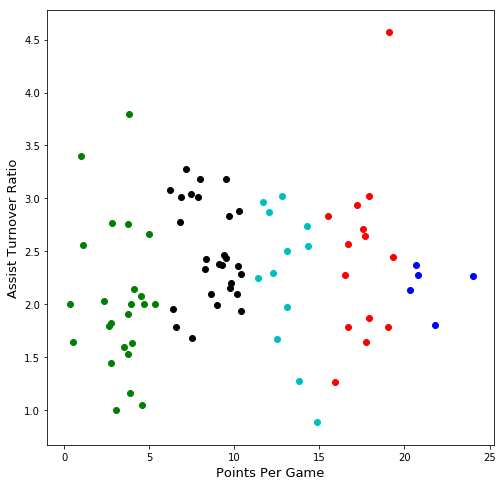

In [37]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(point_guards[['ppg', 'atr']])
point_guards['cluster'] = kmeans.labels_

visualize_clusters(point_guards, num_clusters)

#### In this project, we explored how to segment NBA players into groups with similar traits. Our exploration helped us get a sense of the 5 types of point guards as based on each player's Assist Turnover Ratio and Points Per Game.